# 1 导入相关环境和对应的测试图片

In [3]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML

from typing import Tuple, List, Sequence, Optional, Union
from pathlib import Path
import re
import torch
import tokenizers as tk
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
from torchvision import transforms
from torch import nn, Tensor
from functools import partial
from bs4 import BeautifulSoup as bs
import warnings

from src.model import EncoderDecoder, ImgLinearBackbone, Encoder, Decoder
from src.utils import subsequent_mask, pred_token_within_range, greedy_sampling, bbox_str_to_token_list, cell_str_to_token_list, html_str_to_token_list, build_table_from_html_and_cell, html_table_template
from src.trainer.utils import VALID_HTML_TOKEN, VALID_BBOX_TOKEN, INVALID_CELL_TOKEN
from ocr_system_ch import pred_content

warnings.filterwarnings('ignore')
device = torch.device("cuda:0")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Check all model weights have been downloaded to ./weights
MODEL_FILE_NAME = ["unitable_large_structure.pt", "unitable_large_bbox.pt", "unitable_large_content.pt"]
MODEL_DIR = Path("./weights")

assert all([(MODEL_DIR / name).is_file() for name in MODEL_FILE_NAME]), f"Please download model weights from HuggingFace: https://huggingface.co/poloclub/UniTable/tree/main"

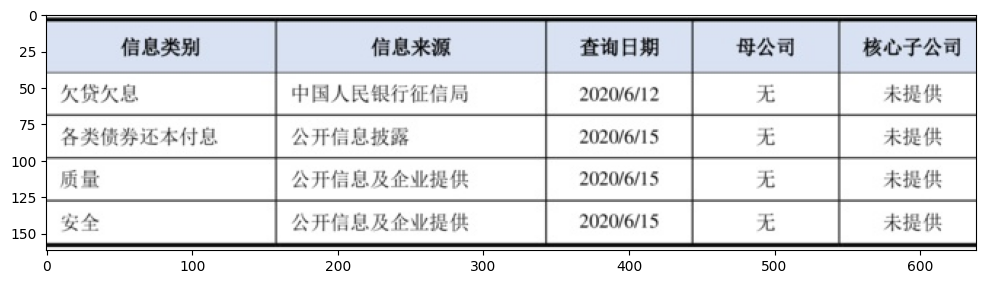

In [6]:
# Load tabular image

# image_name = "test.jpg"
image_name = "test2.jpg"
image_path = f"./{image_name}"

image = Image.open(image_path).convert("RGB")
image_size = image.size

fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(image)

# 2 设置相应的模型信息

In [7]:
# UniTable large model
d_model = 768
patch_size = 16
nhead = 12
dropout = 0.2

backbone = ImgLinearBackbone(d_model=d_model, patch_size=patch_size)
encoder = Encoder(
    d_model=d_model,
    nhead=nhead,
    dropout = dropout,
    activation="gelu",
    norm_first=True,
    nlayer=12,
    ff_ratio=4,
)
decoder = Decoder(
    d_model=d_model,
    nhead=nhead,
    dropout = dropout,
    activation="gelu",
    norm_first=True,
    nlayer=4,
    ff_ratio=4,
)

In [8]:
def autoregressive_decode(
    model: EncoderDecoder,
    image: Tensor,
    prefix: Sequence[int],
    max_decode_len: int,
    eos_id: int,
    token_whitelist: Optional[Sequence[int]] = None,
    token_blacklist: Optional[Sequence[int]] = None,
) -> Tensor:
    model.eval()
    with torch.no_grad():
        memory = model.encode(image)
        context = torch.tensor(prefix, dtype=torch.int32).repeat(image.shape[0], 1).to(device)

    for _ in range(max_decode_len):
        eos_flag = [eos_id in k for k in context]
        if all(eos_flag):
            break

        with torch.no_grad():
            causal_mask = subsequent_mask(context.shape[1]).to(device)
            logits = model.decode(
                memory, context, tgt_mask=causal_mask, tgt_padding_mask=None
            )
            logits = model.generator(logits)[:, -1, :]

        logits = pred_token_within_range(
            logits.detach(),
            white_list=token_whitelist,
            black_list=token_blacklist,
        )

        next_probs, next_tokens = greedy_sampling(logits)
        context = torch.cat([context, next_tokens], dim=1)
    return context

def load_vocab_and_model(
    vocab_path: Union[str, Path],
    max_seq_len: int,
    model_weights: Union[str, Path],
) -> Tuple[tk.Tokenizer, EncoderDecoder]:
    vocab = tk.Tokenizer.from_file(vocab_path)
    model = EncoderDecoder(
        backbone=backbone,
        encoder=encoder,
        decoder=decoder,
        vocab_size=vocab.get_vocab_size(),
        d_model=d_model,
        padding_idx=vocab.token_to_id("<pad>"),
        max_seq_len=max_seq_len,
        dropout=dropout,
        norm_layer=partial(nn.LayerNorm, eps=1e-6)
    )

    model.load_state_dict(torch.load(model_weights, map_location="cpu"))
    model = model.to(device)
    return vocab, model

def image_to_tensor(image: Image, size: Tuple[int, int]) -> Tensor:
    T = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.86597056,0.88463002,0.87491087], std = [0.20686628,0.18201602,0.18485524])
    ])
    image_tensor = T(image)
    image_tensor = image_tensor.to(device).unsqueeze(0)

    return image_tensor

def rescale_bbox(
    bbox: Sequence[Sequence[float]],
    src: Tuple[int, int],
    tgt: Tuple[int, int]
) -> Sequence[Sequence[float]]:
    assert len(src) == len(tgt) == 2
    ratio = [tgt[0] / src[0], tgt[1] / src[1]] * 2
    bbox = [[int(round(i * j)) for i, j in zip(entry, ratio)] for entry in bbox]
    return bbox

# 3 初始化模型，并独立预测不同的子任务（结构信息、单元格检测、内容）

## 3.1 结构信息

In [11]:
# Table structure extraction
vocab, model = load_vocab_and_model(
    vocab_path="./vocab/vocab_html.json",
    max_seq_len=784,
    model_weights=MODEL_DIR / MODEL_FILE_NAME[0],
)

# Image transformation
image_tensor = image_to_tensor(image, size=(448, 448))

# Inference
pred_html = autoregressive_decode(
    model=model,
    image=image_tensor,
    prefix=[vocab.token_to_id("[html]")],
    max_decode_len=512,
    eos_id=vocab.token_to_id("<eos>"),
    token_whitelist=[vocab.token_to_id(i) for i in VALID_HTML_TOKEN],
    token_blacklist = None
)

# Convert token id to token text
pred_html = pred_html.detach().cpu().numpy()[0]
pred_html = vocab.decode(pred_html, skip_special_tokens=False)
pred_html = html_str_to_token_list(pred_html)

print(pred_html)

['<thead>', '<tr>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '</thead>', '<tbody>', '<tr>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '<tr>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '<td>[]</td>', '</tr>', '</tbody>']


## 3.2 单元格包围盒检测

In [12]:
# Table cell bbox detection
vocab, model = load_vocab_and_model(
    vocab_path="./vocab/vocab_bbox.json",
    max_seq_len=1024,
    model_weights=MODEL_DIR / MODEL_FILE_NAME[1],
)

# Image transformation
image_tensor = image_to_tensor(image, size=(448, 448))

# Inference
pred_bbox = autoregressive_decode(
    model=model,
    image=image_tensor,
    prefix=[vocab.token_to_id("[bbox]")],
    max_decode_len=1024,
    eos_id=vocab.token_to_id("<eos>"),
    token_whitelist=[vocab.token_to_id(i) for i in VALID_BBOX_TOKEN[: 449]],
    token_blacklist = None
)

# Convert token id to token text
pred_bbox = pred_bbox.detach().cpu().numpy()[0]
pred_bbox = vocab.decode(pred_bbox, skip_special_tokens=False)

# print(pred_bbox)

[[51, 14, 107, 30], [223, 14, 280, 30], [367, 14, 422, 30], [474, 14, 515, 30], [561, 14, 629, 30], [9, 47, 64, 62], [167, 47, 291, 62], [365, 47, 422, 62], [488, 47, 502, 62], [575, 47, 616, 62], [9, 77, 120, 91], [167, 77, 250, 91], [365, 77, 422, 91], [488, 77, 502, 91], [575, 77, 616, 91], [9, 106, 37, 121], [167, 106, 291, 121], [365, 106, 422, 121], [488, 106, 502, 121], [575, 106, 616, 121], [9, 136, 37, 150], [167, 136, 291, 150], [365, 136, 422, 150], [488, 136, 502, 150], [575, 136, 616, 150]]
len:  25


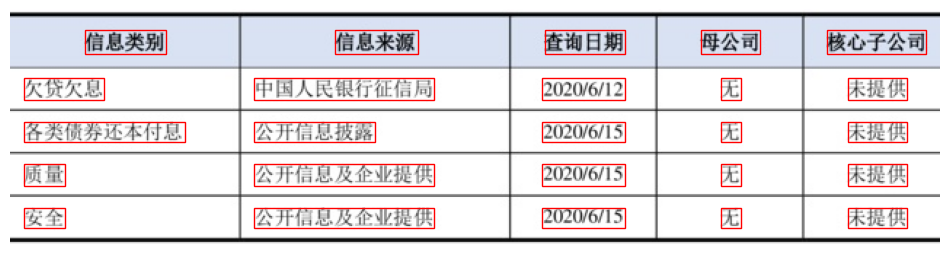

In [13]:
# Visualize detected bbox
pred_bbox = bbox_str_to_token_list(pred_bbox)
pred_bbox = rescale_bbox(pred_bbox, src=(448, 448), tgt=image_size)

fig, ax = plt.subplots(figsize=(12, 10))
for i in pred_bbox:
    rect = patches.Rectangle(i[:2], i[2] - i[0], i[3] - i[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
ax.set_axis_off()
ax.imshow(image)

print(pred_bbox)
print("len: ", len(pred_bbox))

## 3.3 调用ocr实现文字内容子网络

In [14]:
vocab, model = load_vocab_and_model(
    vocab_path="./vocab/vocab_cell_6k.json",
    max_seq_len=200,
    model_weights=MODEL_DIR / MODEL_FILE_NAME[2],
)

# Cell image cropping and transformation
image_tensor = [image_to_tensor(image.crop(bbox), size=(112, 448)) for bbox in pred_bbox]
image_tensor = torch.cat(image_tensor, dim=0)

# Inference
pred_cell = autoregressive_decode(
    model=model,
    image=image_tensor,
    prefix=[vocab.token_to_id("[cell]")],
    max_decode_len=200,
    eos_id=vocab.token_to_id("<eos>"),
    token_whitelist=None,
    token_blacklist = [vocab.token_to_id(i) for i in INVALID_CELL_TOKEN]
)

# Convert token id to token text
pred_cell = pred_cell.detach().cpu().numpy()
pred_cell = vocab.decode_batch(pred_cell, skip_special_tokens=False)
pred_cell = [cell_str_to_token_list(i) for i in pred_cell]
pred_cell = [re.sub(r'(\d).\s+(\d)', r'\1.\2', i) for i in pred_cell]

# pred_cell = pred_content(image ,pred_bbox).result_cell() # trying to recognize Chinese

print(pred_cell, len(pred_cell))

2025-05-07 10:27:15.032 | INFO     | ocr_system_base:load_model:37 - Loading model...
2025-05-07 10:27:15.034 | INFO     | ocr_system_base:load_model:42 - use gpu: True
2025-05-07 10:27:15.036 | INFO     | ocr_system_base:load_model:43 - CUDA_VISIBLE_DEVICES: 0
2025-05-07 10:27:15.687 | INFO     | ppocr.infer.predict_system_v2:__call__:93 - dt_boxes num : 25, elapse : 0.30580759048461914
2025-05-07 10:27:16.606 | INFO     | ppocr.infer.predict_system_v2:__call__:187 - rec_res num  : 25, elapse : 0.9012589454650879
2025-05-07 10:27:16.716 | INFO     | ocr_system_base:__call__:173 - The visualized image saved in ./test/draw_img.jpg


['信息类别 ', '信息来源 ', '查询日期 ', '母公司 ', '核心子公司 ', '欠贷欠息 ', '中国人民银行征信局 ', '2020/6/12 ', '无 ', '未提供 ', '各类债券还本付息 ', '公开信息披露 ', '2020/6/15 ', '无 ', '未提供 ', '质量 ', '公开信息及企业提供 ', '2020/6/15 ', '无 ', '未提供 ', '安全 ', '公开信息及企业提供 ', '2020/6/15 ', '无 ', '未提供 '] 25


## 3.4 整合三个子网络，预测输出

In [15]:
# Combine the table structure and cell content
pred_code = build_table_from_html_and_cell(pred_html, pred_cell)
pred_code = "".join(pred_code)
pred_code = html_table_template(pred_code)

# Display the HTML table
soup = bs(pred_code)
table_code = soup.prettify()
display(HTML(table_code))

信息类别,信息来源,查询日期,母公司,核心子公司
欠贷欠息,中国人民银行征信局,2020/6/12,无,未提供
各类债券还本付息,公开信息披露,2020/6/15,无,未提供
质量,公开信息及企业提供,2020/6/15,无,未提供
安全,公开信息及企业提供,2020/6/15,无,未提供


## 3.5 完整html输出并保存

In [16]:
import os

save_name = os.path.splitext(image_name)[0]
save_path = f'./{save_name}_html.html'

# 保存输出
try:
    with open(save_path, 'w', encoding='utf-8') as f:
        f.write(table_code)
except Exception as e:
        print(f"Error saving file: {e}")
        
# Raw HTML table code
print(table_code)

<html>
 <head>
  <meta charset="utf-8"/>
  <style>
   table, th, td {
            border: 1px solid black;
            font-size: 10px;
        }
  </style>
 </head>
 <body>
  <table frame="hsides" rules="groups" width="100%%">
   <thead>
    <tr>
     <td>
      信息类别
     </td>
     <td>
      信息来源
     </td>
     <td>
      查询日期
     </td>
     <td>
      母公司
     </td>
     <td>
      核心子公司
     </td>
    </tr>
   </thead>
   <tbody>
    <tr>
     <td>
      欠贷欠息
     </td>
     <td>
      中国人民银行征信局
     </td>
     <td>
      2020/6/12
     </td>
     <td>
      无
     </td>
     <td>
      未提供
     </td>
    </tr>
    <tr>
     <td>
      各类债券还本付息
     </td>
     <td>
      公开信息披露
     </td>
     <td>
      2020/6/15
     </td>
     <td>
      无
     </td>
     <td>
      未提供
     </td>
    </tr>
    <tr>
     <td>
      质量
     </td>
     <td>
      公开信息及企业提供
     </td>
     <td>
      2020/6/15
     </td>
     <td>
      无
     </td>
     <td>
      未提供
     </td>
    </tr>
    <